In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.models.panel import FixedEffects
from src.models.linreg import LinReg
from src.displays.display_linear import display_models
from src.diagnostics.diagnostics import f_test

In [2]:
df = pd.read_csv('../data/fatalities.csv')
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns ")
"""create death per 10000"""
df['d/10k'] = df['fatal'] / df['pop'] * 10000
df.head()

The dataset has 336 rows and 35 columns 


,rownames,state,year,spirits,unemp,income,emppop,beertax,baptist,mormon,...,afatal,pop,pop1517,pop1820,pop2124,milestot,unempus,emppopus,gsp,d/10k
0,1,al,1982,1.37,14.4,10544.152344,50.692039,1.539379,30.355700,0.32829,...,309.437988,3942002.25,208999.593750,221553.43750,290000.06250,28516.0,9.7,57.799999,-0.022125,2.12836
1,2,al,1983,1.36,13.7,10732.797852,52.147030,1.788991,30.333599,0.34341,...,341.834015,3960008.00,202000.078125,219125.46875,290000.15625,31032.0,9.6,57.900002,0.046558,2.34848
2,3,al,1984,1.32,11.1,11108.791016,54.168087,1.714286,30.311501,0.35924,...,304.872009,3988991.75,196999.968750,216724.09375,288000.15625,32961.0,7.5,59.500004,0.062798,2.33643
3,4,al,1985,1.28,8.9,11332.626953,55.271137,1.652542,30.289499,0.37579,...,276.742004,4021007.75,194999.734375,214349.03125,284000.31250,35091.0,7.2,60.100002,0.027490,2.19348
4,5,al,1986,1.23,9.8,11661.506836,56.514496,1.609907,30.267401,0.39311,...,360.716003,4049993.75,203999.890625,212000.00000,263000.28125,36259.0,7.0,60.700001,0.032143,2.66914


In [3]:
df['state'].unique()

array(['al', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'id', 'il',
       'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms',
       'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh',
       'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va',
       'wa', 'wv', 'wi', 'wy'], dtype=object)

The US traffic fatalities dataset comprises annual data from 1982 to 1988 for the 48 contiguous states, excluding Alaska and Hawaii, resulting in 336 observations across 34 variables. This rich dataset includes information on traffic fatalities, alcohol consumption and policies (like beer tax and legal drinking age), religious demographics, and economic indicators such as income and unemployment rates. Key variables include state and year identifiers, various demographic and policy-related factors, and several specific metrics on vehicle fatalities, providing a comprehensive view of traffic-related fatalities and their potential influencing factors in the US during this period.

The Fixed Effects (FE) model is a powerful tool for causal inference, especially in panel data settings where we have repeated observations of the same entities (like villages in your case) over time. This method is particularly useful when trying to control for unobserved, time-invariant characteristics of these entities. Let's walk through the assumptions and application of the FE model, particularly in the context of your dataset from Edward Miguel's study on "Poverty and Witch Killing."

### Assumptions of the Fixed Effects Model

1. **Linearity**: The relationship between the independent variables and the dependent variable is linear. The model typically takes the form:
   $$ Y_{it} = \alpha + \beta X_{it} + \lambda_i + \epsilon_{it} $$
   Where $Y_{it}$ is the dependent variable (e.g., witch murders in a village at time $t$), $X_{it}$ are independent variables (like indicators for drought, disease, etc.), $\lambda_i$ is the unobserved time-invariant effect for each entity (village), and $\epsilon_{it}$ is the error term.

2. **Time-Invariant Entity Effects**: Each entity (village) has unique attributes that do not change over time, captured by $\lambda_i$. These could be factors like geographical characteristics, cultural factors, etc., that are not directly measured but could influence the dependent variable.

3. **No Omitted Time-Variant Variables**: All relevant time-varying variables that could affect the dependent variable are included in the model. Omitting such variables can lead to biased estimates.

4. **Exogeneity**: The independent variables are not correlated with the error term, conditional on the fixed effects. This means that after controlling for the fixed effects, the independent variables should not be systematically related to other unobserved factors that influence the dependent variable.

### Application to the Dataset

In this dataset, we can apply the Fixed Effects model to examine the effect of various factors (like drought, disease, famine) on witch murders while controlling for unobserved, time-invariant characteristics of each village. 

For example, suppose we are interested in the effect of a drought on witch murders. The FE model controls for unobserved characteristics of each village that might influence both the likelihood of a drought and the occurrence of witch murders (like geographical location, traditional practices, etc.), isolating the effect of the drought itself.

### Cluster-Robust Standard Errors

In the context of this dataset, it's essential to consider cluster-robust standard errors, especially if there's reason to believe that error terms within the same village over time might be correlated (e.g., due to local economic or social factors that persist across years). Cluster-robust standard errors adjust for such within-cluster (village) correlation, providing more accurate estimates of the standard errors and hence more reliable statistical inference. 

In summary, the Fixed Effects model, combined with cluster-robust standard errors, offers a robust framework for analyzing the causal effects of time-varying factors in panel data while controlling for unobserved, time-invariant characteristics of the entities being studied.

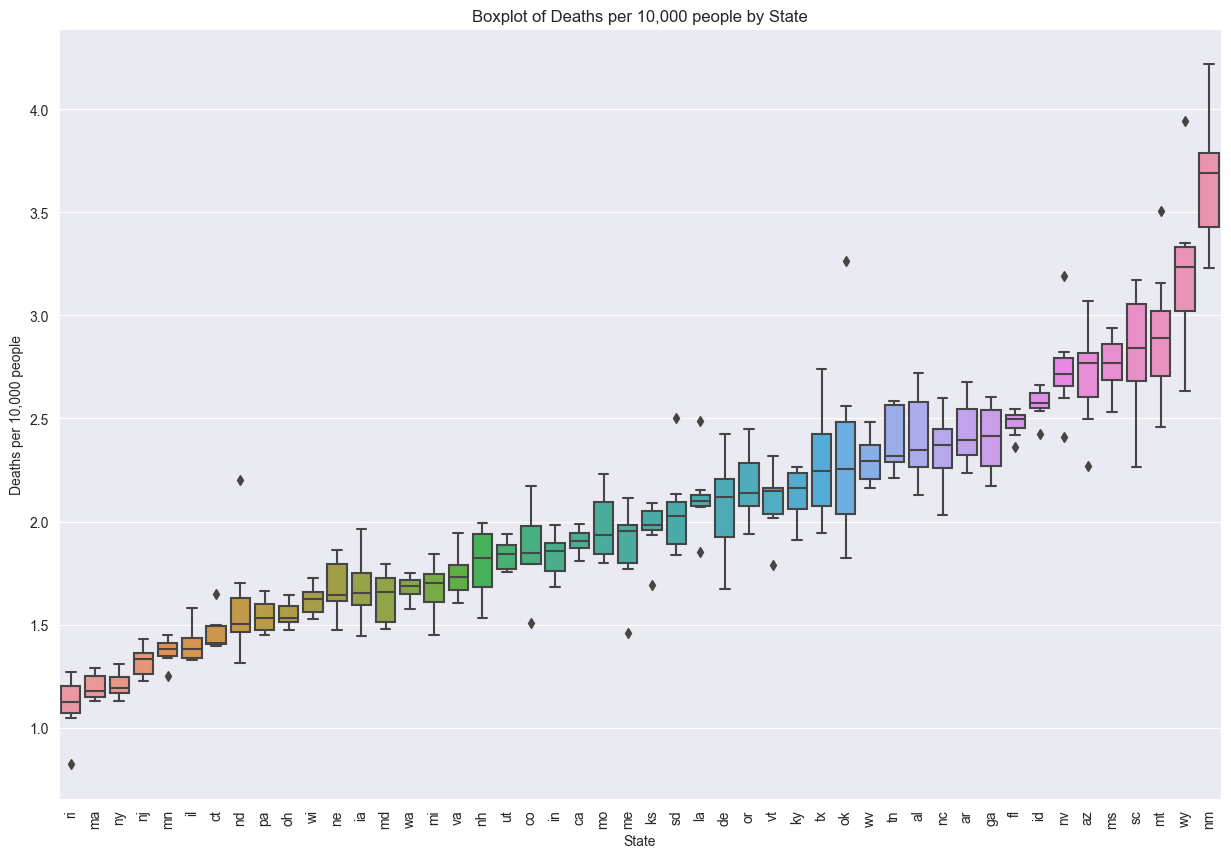

In [4]:
"""Boxplot showing state level heterogeneity in deaths per 10000"""

grouped = df.groupby('state')['d/10k'].median().sort_values()
ordered_df = df.set_index('state').loc[grouped.index].reset_index()

plt.figure(figsize=(15, 10))
sns.boxplot(x='state', y='d/10k', data=ordered_df)
plt.xticks(rotation=90)  
plt.xlabel('State')
plt.ylabel('Deaths per 10,000 people')
plt.title('Boxplot of Deaths per 10,000 people by State')
plt.show()


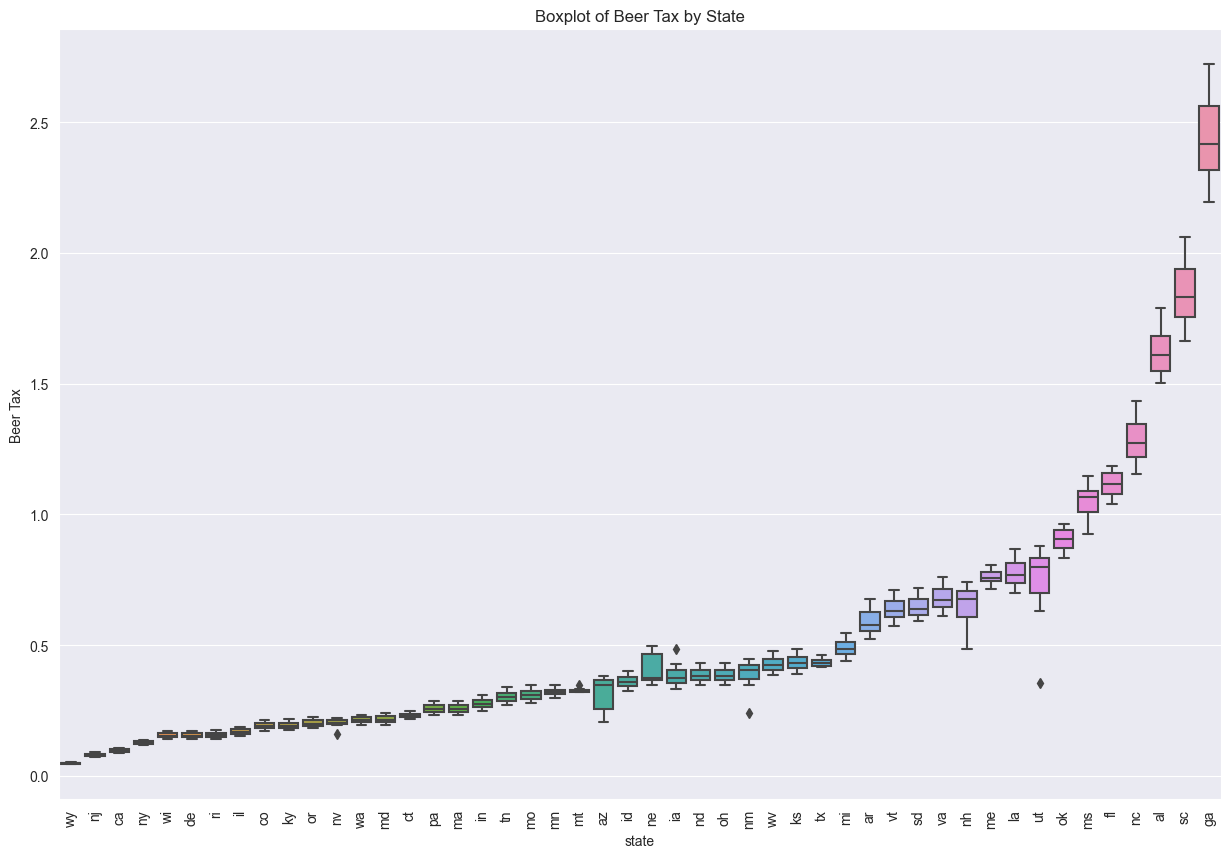

In [5]:
"""Boxplot showing state level heterogeneity in beer tax by state"""

grouped_beertax = df.groupby('state')['beertax'].median().sort_values()
ordered_df_beertax = df.set_index('state').loc[grouped_beertax.index].reset_index()

plt.figure(figsize=(15, 10))
sns.boxplot(x='state', y='beertax', data=ordered_df_beertax)
plt.xticks(rotation=90)
plt.ylabel('Beer Tax')
plt.title('Boxplot of Beer Tax by State')
plt.show()

In [6]:
"""Lets build a naive linear model to see if there is a relationship between beer tax and deaths per 10,000 people"""
base = LinReg(df = df,
              outcome='d/10k',
              independent=['beertax'])

display_models([base])


This naive regression shockingly shows that increasing beertax would lead to more deaths!  This seems very counterintuitive and is most likely due to omitted variable bias. While we could add more covariates to attempt to correct for this, we will instead use a fixed effects model to control for unobserved time-invariant characteristics of each state.

In [7]:
fe1 = FixedEffects(df = df,
                   outcome='d/10k',
                   independent=['beertax'],
                   fixed = ['state'],
                   standard_error_type='clustered')

display_models([base, fe1])

In [8]:
len(fe1.independent_vars)

48

In [9]:
fe1.independent_data

,beertax,dummy_state_ar,dummy_state_az,dummy_state_ca,dummy_state_co,dummy_state_ct,dummy_state_de,dummy_state_fl,dummy_state_ga,dummy_state_ia,...,dummy_state_sd,dummy_state_tn,dummy_state_tx,dummy_state_ut,dummy_state_va,dummy_state_vt,dummy_state_wa,dummy_state_wi,dummy_state_wv,dummy_state_wy
0,1.539379,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.788991,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.714286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.652542,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.609907,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.049451,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
332,0.047669,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
333,0.046440,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
334,0.045000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Note that in this model, the coefficient estimate of tax is now different compared to the naive approach, and it is negative as we expect.
The estimated coefficient on beer tax is now negative and significantly different from zero. Its interpretation is that raising the beer tax by 1% causes the traffic fatalities rate to decrease by 0.65 per 10,000 people. Additionally, we see that our fixed effects model now accounts for much more of the variation of the data as our r^2 value increase from 9% to approximately 91%. 

In [10]:
"""Lets build out this model to account for time level fixed effects.  This will allow for us to contro for time level onobserved effects such as the state of the wider economy or global geopolitical events"""

fe2 = FixedEffects(df = df,
                          outcome='d/10k',
                          independent=['beertax'],
                          fixed = ['state', 'year'],
                          standard_error_type='clustered')

display_models([base, fe1, fe2])

In [11]:
"""Test for significance of state fixed effects"""

f_test(base, fe1)

F-Test Results for significance of add effects
Alternative Hypothesis: Added covariates are significant


,F-Statistic,DFN,DFD,p-value
0,52.179194,47,287,1.110223e-16


In [12]:

"""Test for significance of year fixed effects"""

f_test( fe1, fe2)

F-Test Results for significance of add effects
Alternative Hypothesis: Added covariates are significant


,F-Statistic,DFN,DFD,p-value
0,2.011676,6,281,0.064199


Looking at the results of the f tests above we confirm our suspicions that there are significant state level fixed effects.  However, we do not find significant year level fixed effects.  This is not surprising as we are only looking at a 7 year period.  If we were to look at a longer time period we would expect to see significant year level fixed effects.